# -*- coding: utf-8 -*-
# 2023 https://github.com/john-fante
# https://www.kaggle.com/banddaniel

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from scipy.io.arff import loadarff

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dropout, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [2]:
# reading .arff file and converting dataframe
def arff_to_pd(path):
  data = loadarff(path)
  raw_data, meta_data = data

  cols = []
  for col_name in meta_data:
    cols.append(col_name)

  data2d = np.zeros([ raw_data.shape[0], len(cols) ])

  for row_number in range(raw_data.shape[0]):
    for col_number in range(len(cols)):
      data2d[row_number][col_number] = raw_data[row_number][col_number]

  df = pd.DataFrame(data2d, columns = cols)

  return df


# plotting random examples
def plot_samples(df):
  pos = df[df.target == 1]
  neg = df[df.target== -1 ]

  idx_pos = random.randint(0, pos.shape[0])
  idx_neg = random.randint(0, neg.shape[0])

  fig,axs = plt.subplots(1,2, figsize=(12,5), sharey=True)
  axs[0].plot(pos.iloc[idx_pos, :-1])
  axs[0].set_title('positive example no: ' + str(idx_pos))

  axs[1].plot(neg.iloc[idx_neg, : -1])
  axs[1].set_title('negative example no: ' + str(idx_neg))

  plt.tight_layout()

  plt.show()





In [3]:
train_data = arff_to_pd('/content/drive/MyDrive/ECG200/ECG200_TRAIN.arff')
test_data = arff_to_pd('/content/drive/MyDrive/ECG200/ECG200_TEST.arff')

print(train_data.shape)
print(test_data.shape)

(100, 97)
(100, 97)


In [4]:
train_data

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att88,att89,att90,att91,att92,att93,att94,att95,att96,target
0,0.502055,0.542163,0.722383,1.428885,2.136516,2.281149,1.936274,1.468890,1.008845,0.380282,...,0.610298,0.638894,0.684679,0.583238,0.640522,0.708585,0.705011,0.713815,0.433765,-1.0
1,0.147647,0.804668,0.367771,0.243894,0.026614,-0.274402,0.096731,-0.747731,-1.609777,-1.179593,...,-0.400228,0.176084,1.111768,2.438428,2.734889,1.736054,0.036857,-1.265074,-0.208024,1.0
2,0.316646,0.243199,0.370471,1.063738,1.678187,1.759558,1.697717,1.612159,1.168188,0.499957,...,0.610621,0.552900,0.566786,0.604002,0.777068,0.812345,0.748848,0.818042,0.539347,-1.0
3,1.168874,2.075901,1.760141,1.606446,1.949046,1.302842,0.459332,0.516412,0.852180,0.989227,...,0.723888,1.323947,2.136488,1.746597,1.470220,1.893512,1.256949,0.800407,0.731540,-1.0
4,0.648658,0.752026,2.636231,3.455716,2.118157,0.520620,-0.188627,0.780818,0.933775,0.701402,...,-0.136787,-0.340237,-0.089441,-0.080297,-0.192584,-0.304704,-0.454556,0.314590,0.582190,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.581277,0.876188,1.042767,1.796120,2.541399,2.246653,1.500387,1.031521,0.382672,-0.197561,...,0.907869,0.916457,0.923975,0.767357,0.656223,0.762357,0.501373,-0.333336,-0.524546,1.0
96,2.689017,2.708703,2.008381,2.235800,1.516982,0.029916,-0.561346,-0.793702,-0.979371,-1.288162,...,-0.072176,-0.082738,-0.138468,-0.120396,-0.089411,-0.243141,-0.119710,0.124042,0.273463,-1.0
97,0.197677,0.455417,0.973110,1.935956,2.259463,1.741341,1.158296,0.418241,-0.071605,-0.241250,...,0.325569,0.247991,0.184127,0.050358,0.241988,0.331451,-0.120006,0.042423,0.343293,-1.0
98,0.179500,1.038409,1.946421,2.705141,1.670706,-0.101167,-1.578876,-0.750906,0.175310,0.064901,...,0.330489,0.111953,0.448948,0.567132,0.136757,0.444768,0.151050,0.193378,0.451709,1.0


In [5]:
X_train = train_data.iloc[:,0:-1]
y_train = train_data.iloc[:,-1]

X_test = test_data.iloc[:,0:-1]
y_test = test_data.iloc[:,-1]



print(X_train.shape)
print(y_train.shape)

(100, 96)
(100,)


In [6]:
# labels encoding (-1,1) -> 0,1
lb = LabelEncoder()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

In [7]:
X_train = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = np.array(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)

print(X_train.shape)
print(X_test.shape)

(100, 96, 1)
(100, 96, 1)


In [8]:
# shuffling dataset
idx = np.random.permutation(len(X_train))

X_train = X_train[idx]
y_train = y_train[idx]


print(X_train.shape)
print(y_train.shape)


(100, 96, 1)
(100,)


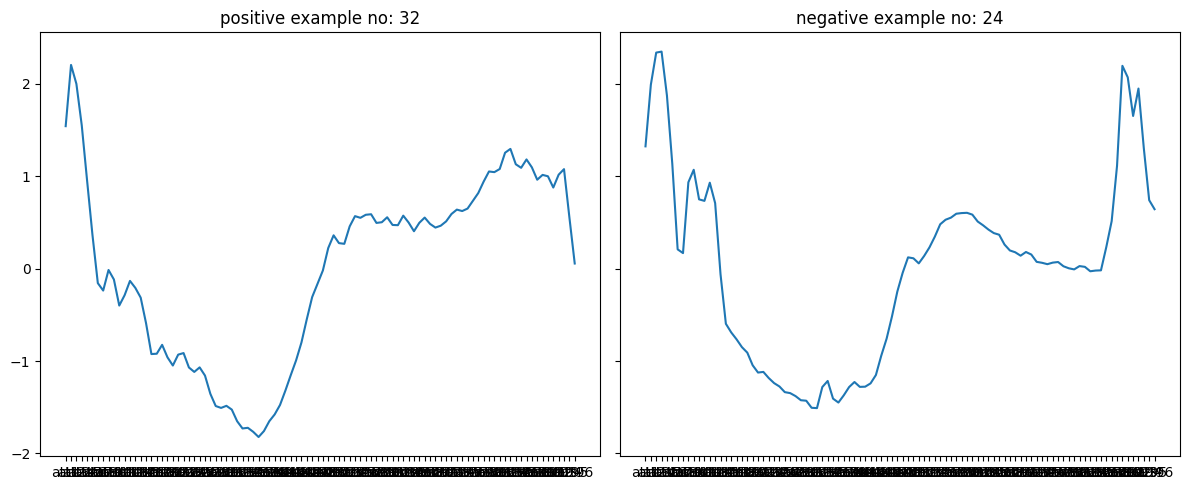

In [71]:
plot_samples(test_data)

In [67]:
inp = Input(shape = X_train.shape[1:])

conv1 = Conv1D(64, 3, padding='same', activation = 'relu')(inp)
conv1 = Dropout(0.1)(conv1)

conv2 = Conv1D(128, 3, padding='same', activation = 'relu')(conv1)
conv2 = BatchNormalization()(conv2)
conv2 = Dropout(0.1)(conv2)


conv3 = Conv1D(128, 3, padding='same', activation = 'relu')(conv2)
conv3 = BatchNormalization()(conv3)
conv3 = Dropout(0.1)(conv3)

pool = GlobalAveragePooling1D()(conv3)

out = Dense(2, activation='softmax')(pool)

model = Model(inputs = inp, outputs= out)
model.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy', metrics =['sparse_categorical_accuracy'] )
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 96, 1)]           0         
                                                                 
 conv1d_31 (Conv1D)          (None, 96, 64)            256       
                                                                 
 dropout_31 (Dropout)        (None, 96, 64)            0         
                                                                 
 conv1d_32 (Conv1D)          (None, 96, 128)           24704     
                                                                 
 batch_normalization_29 (Bat  (None, 96, 128)          512       
 chNormalization)                                                
                                                                 
 dropout_32 (Dropout)        (None, 96, 128)           0         
                                                          

In [62]:
callbacks = [ ModelCheckpoint('best.h5', save_best_only = True, monitor = 'val_loss'),
             EarlyStopping(monitor = 'val_loss', patience = 8, verbose = 1 ),
              ReduceLROnPlateau(monitor = 'val_loss', min_lr = 0.0001, factor = 0.5, patience = 3) ]


hist = model.fit(X_train, y_train, batch_size = 8, epochs = 50 , callbacks = callbacks,
                 validation_split = 0.2 , verbose = 1)

Epoch 1/50
10/10 [==============================] - 1s 34ms/step - loss: 0.3467 - sparse_categorical_accuracy: 0.8375 - val_loss: 0.4389 - val_sparse_categorical_accuracy: 0.7500 - lr: 0.0010
Epoch 2/50
10/10 [==============================] - 0s 24ms/step - loss: 0.2809 - sparse_categorical_accuracy: 0.8875 - val_loss: 0.4574 - val_sparse_categorical_accuracy: 0.7500 - lr: 0.0010
Epoch 3/50
10/10 [==============================] - 0s 26ms/step - loss: 0.3822 - sparse_categorical_accuracy: 0.8250 - val_loss: 0.4409 - val_sparse_categorical_accuracy: 0.7500 - lr: 0.0010
Epoch 4/50
10/10 [==============================] - 0s 24ms/step - loss: 0.3044 - sparse_categorical_accuracy: 0.8875 - val_loss: 0.4778 - val_sparse_categorical_accuracy: 0.8000 - lr: 0.0010
Epoch 5/50
10/10 [==============================] - 0s 28ms/step - loss: 0.2808 - sparse_categorical_accuracy: 0.9250 - val_loss: 0.4324 - val_sparse_categorical_accuracy: 0.8000 - lr: 5.0000e-04
Epoch 6/50
10/10 [==================

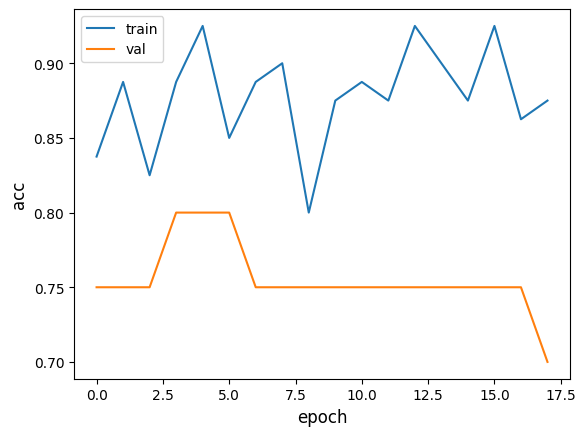

In [76]:
plt.plot(hist.history['sparse_categorical_accuracy'])
plt.plot(hist.history['val_sparse_categorical_accuracy'])
plt.ylabel('acc', fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()

In [77]:
model = tf.keras.models.load_model('/content/best.h5')
model.evaluate(X_test,y_test)

4/4 [==============================] - 0s 12ms/step - loss: 0.4125 - sparse_categorical_accuracy: 0.8300


[0.4125179350376129, 0.8299999833106995]

In [64]:
pred = model.predict(X_test)

y_pred = []
for i in range(len(pred)):
  y_pred.append( np.argmax(pred[i]))

4/4 [==============================] - 0s 10ms/step


In [65]:
from sklearn.metrics import classification_report, confusion_matrix

rep = classification_report(y_test, y_pred)

print(rep)

              precision    recall  f1-score   support

           0       0.71      0.89      0.79        36
           1       0.93      0.80      0.86        64

    accuracy                           0.83       100
   macro avg       0.82      0.84      0.82       100
weighted avg       0.85      0.83      0.83       100



<Axes: >

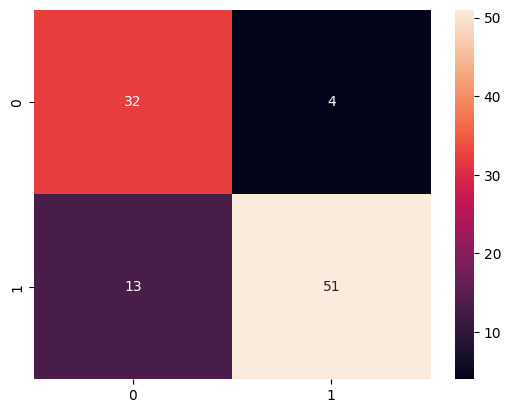

In [66]:
import seaborn as sns

cf = confusion_matrix(y_test, y_pred)
sns.heatmap(cf, annot =True)


